# Arabic Handwritten Characters Recognition using Convolutional Neural Network and Support Vector Machine

In [23]:
%pip install np_utils
%pip install tqdm
%matplotlib inline

import os
import math
import random
import itertools
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense,Flatten,MaxPool2D,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization,GlobalAveragePooling2D,Input, Lambda
from keras import regularizers
from keras.models import load_model
from keras.utils import to_categorical
from keras.optimizers import Adam

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image, display
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,NMF, FactorAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

np.random.seed(2)
sns.set(style='white', context='notebook', palette='deep')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import data and preprocessing

Arabic Characters list to map the labels with the letters

In [24]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
arabic_characters

['alef',
 'beh',
 'teh',
 'theh',
 'jeem',
 'hah',
 'khah',
 'dal',
 'thal',
 'reh',
 'zain',
 'seen',
 'sheen',
 'sad',
 'dad',
 'tah',
 'zah',
 'ain',
 'ghain',
 'feh',
 'qaf',
 'kaf',
 'lam',
 'meem',
 'noon',
 'heh',
 'waw',
 'yeh']

## Importing Dataset

In [25]:
x_train = pd.read_csv(r"C:\Users\arfan\OneDrive\Desktop\Sem 6\CSP650\Dataset\csvTrainImages 13440x1024.csv",header=None).to_numpy()
y_train = pd.read_csv(r"C:\Users\arfan\OneDrive\Desktop\Sem 6\CSP650\Dataset\csvTrainLabel 13440x1.csv", header=None).to_numpy()-1

x_test = pd.read_csv(r"C:\Users\arfan\OneDrive\Desktop\Sem 6\CSP650\Dataset\csvTestImages 3360x1024.csv",header=None).to_numpy()
y_test = pd.read_csv(r"C:\Users\arfan\OneDrive\Desktop\Sem 6\CSP650\Dataset\csvTestLabel 3360x1.csv", header=None,).to_numpy()-1

print("x_train.shape =", x_train.shape)
print("y_train.shape =", y_train.shape)
print("x_test.shape =", x_test.shape)
print("y_test.shape =", y_test.shape)

x_train.shape = (13440, 1024)
y_train.shape = (13440, 1)
x_test.shape = (3360, 1024)
y_test.shape = (3360, 1)


In [26]:
x_train = x_train.reshape(-1,32,32)
x_test = x_test.reshape(-1,32,32)
x_train = x_train/255
x_test = x_test/255
# for some reason the images are flipped and rotated
# so we transpose each image to be in the correct shape
x_train = np.array([image.T for image in x_train])
x_test = np.array([image.T for image in x_test])

# shuffle
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

print(x_train.shape, x_test.shape)

KeyboardInterrupt: 

## Displaying Sample Images from Dataset

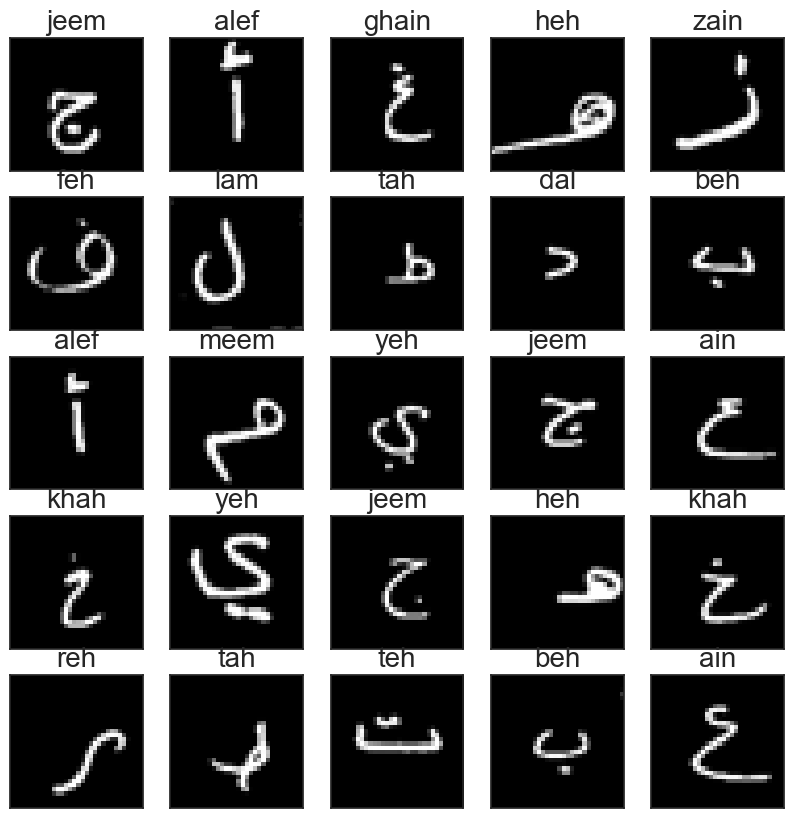

In [ ]:
ra = np.random.randint(0, 13440, size=25)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[ra[i]].reshape(32,32),"gray")
    plt.title(arabic_characters[int(y_train[ra[i]][0])], fontsize = 20)
plt.show()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
# Converting the class vector in integers to binary class matrix

from keras.utils import to_categorical
y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)

y_train_h = to_categorical(y_train)
y_val_h = to_categorical(y_val)
y_test_h = to_categorical(y_test)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_h.shape, y_val_h.shape, y_test_h.shape)

(9408,) (4032,) (3360,)
(9408, 28) (4032, 28) (3360, 28)


## Convolutional Neural Network Model

Using data generater to extend the training set and avoid overfitting

In [ ]:
x_train = x_train.reshape(-1,32,32, 1)
x_val = x_val.reshape(-1,32,32, 1)
x_test = x_test.reshape(-1,32,32, 1)

train_datagen=ImageDataGenerator(
    #rescale=1/255, # Normalize the new images
    zoom_range=0.2, #the amount of zooming u need
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20,
)
train_generator=train_datagen.flow(
    x_train ,y_train ,batch_size=64
)

test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow(
    x_val ,y_val ,batch_size=64

)

In [ ]:
earlystop = EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_accuracy',
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate_reduction]

**The ConvNet architecture is the same proposed in the paper 'Arabic Handwritten Characters Recognition using Convolutional Neural Network'**

![ConvNet Structure](https://www.researchgate.net/profile/Hazem-El-Bakry/publication/313891953/figure/fig4/AS:464684475260928@1487800820810/The-proposed-CNN-for-Arabic-handwritten-character-recognition_W640.jpg)

In [ ]:
# Set the CNN model

from keras import regularizers

model=Sequential()

model.add(Conv2D(80,(5,5),activation='relu',input_shape=(32,32,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(1024,activation='relu', name='featurs'))
#model.add(Dropout(0.5))
model.add(Dense(28, kernel_regularizer=keras.regularizers.l2(0.01) ,activation='softmax'))

In [ ]:
model.compile(optimizer= 'adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 80)        2080      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        128064    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 featurs (Dense)             (None, 1024)              1

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model Fitting

In [ ]:
model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    verbose=1,
    #callbacks=callbacks
)

Epoch 1/50
147/147 [==============================] - 16s 105ms/step - loss: 2.2893 - accuracy: 0.3641 - val_loss: 1.0692 - val_accuracy: 0.6848
Epoch 2/50
147/147 [==============================] - 15s 101ms/step - loss: 1.2386 - accuracy: 0.6390 - val_loss: 0.7631 - val_accuracy: 0.7959
Epoch 3/50
147/147 [==============================] - 15s 102ms/step - loss: 0.9646 - accuracy: 0.7199 - val_loss: 0.5550 - val_accuracy: 0.8569
Epoch 4/50
147/147 [==============================] - 16s 108ms/step - loss: 0.7934 - accuracy: 0.7807 - val_loss: 0.5263 - val_accuracy: 0.8641
Epoch 5/50
147/147 [==============================] - 15s 100ms/step - loss: 0.6976 - accuracy: 0.8046 - val_loss: 0.5119 - val_accuracy: 0.8728
Epoch 6/50
147/147 [==============================] - 14s 93ms/step - loss: 0.6462 - accuracy: 0.8190 - val_loss: 0.4098 - val_accuracy: 0.9003
Epoch 7/50
147/147 [==============================] - 14s 93ms/step - loss: 0.5902 - accuracy: 0.8379 - val_loss: 0.4587 - val_accu

<Axes: >

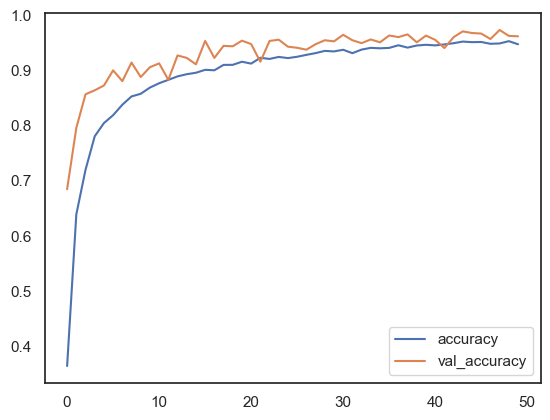

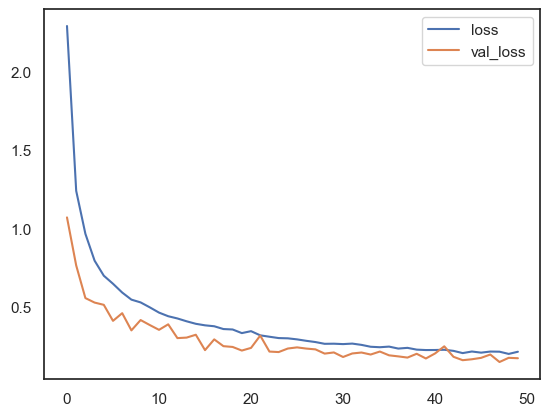

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [ ]:
model.evaluate(test_generator)


63/63 [==============================] - 1s 20ms/step - loss: 0.1715 - accuracy: 0.9621


[0.1714886575937271, 0.9620535969734192]

In [ ]:
pred = model.predict(x_test)
print(pred.shape)
pred = np.argmax(pred, axis=1)
print(pred)

105/105 [==============================] - 1s 12ms/step
(3360, 28)
[ 4 22 23 ...  8  4 18]


<Axes: >

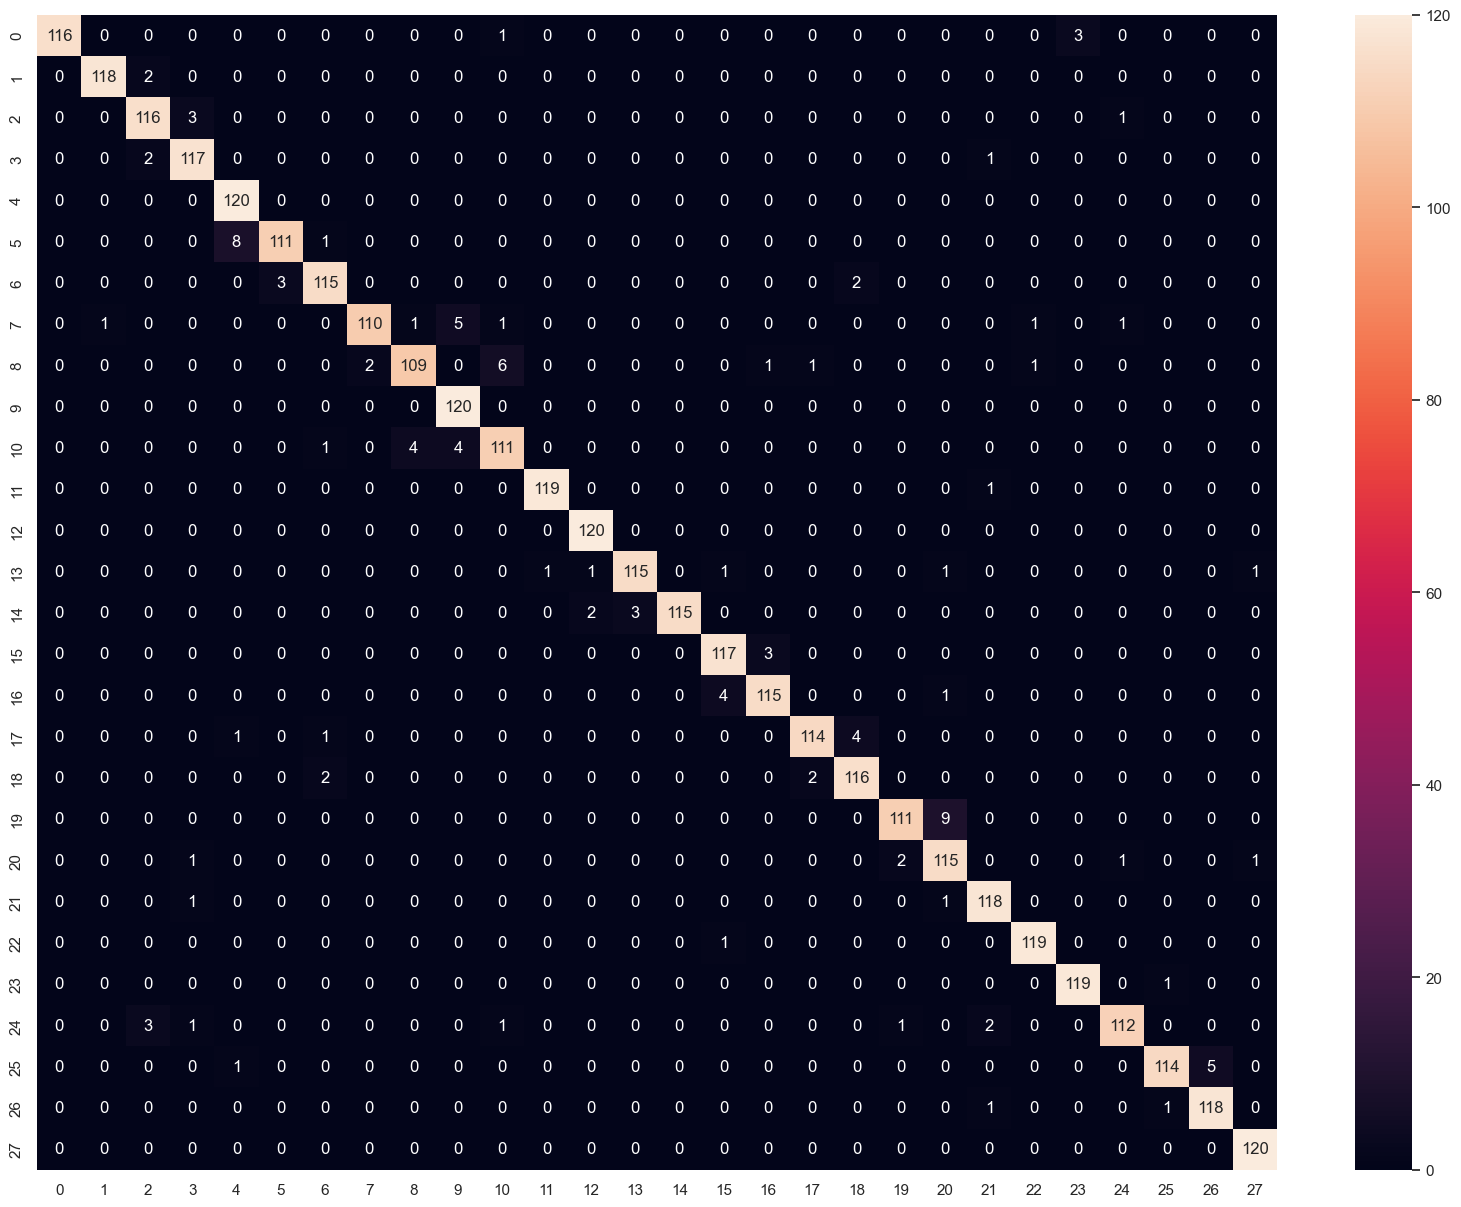

In [ ]:
y_true = np.argmax(y_test_h, axis=1)
cm = confusion_matrix(y_true, pred)

plt.figure(figsize=(20,15))
sns.heatmap(cm, annot=True, fmt="d")

In [ ]:
model.save('CNN_Epoch50_(8.3).h5')

## The Accuracy Report of the CNN model

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       120
           1       0.99      0.98      0.99       120
           2       0.94      0.97      0.95       120
           3       0.95      0.97      0.96       120
           4       0.92      1.00      0.96       120
           5       0.97      0.93      0.95       120
           6       0.96      0.96      0.96       120
           7       0.98      0.92      0.95       120
           8       0.96      0.91      0.93       120
           9       0.93      1.00      0.96       120
          10       0.93      0.93      0.93       120
          11       0.99      0.99      0.99       120
          12       0.98      1.00      0.99       120
          13       0.97      0.96      0.97       120
          14       1.00      0.96      0.98       120
          15       0.95      0.97      0.96       120
          16       0.97      0.96      0.96       120
          17       0.97    

## Misclassification Analysis

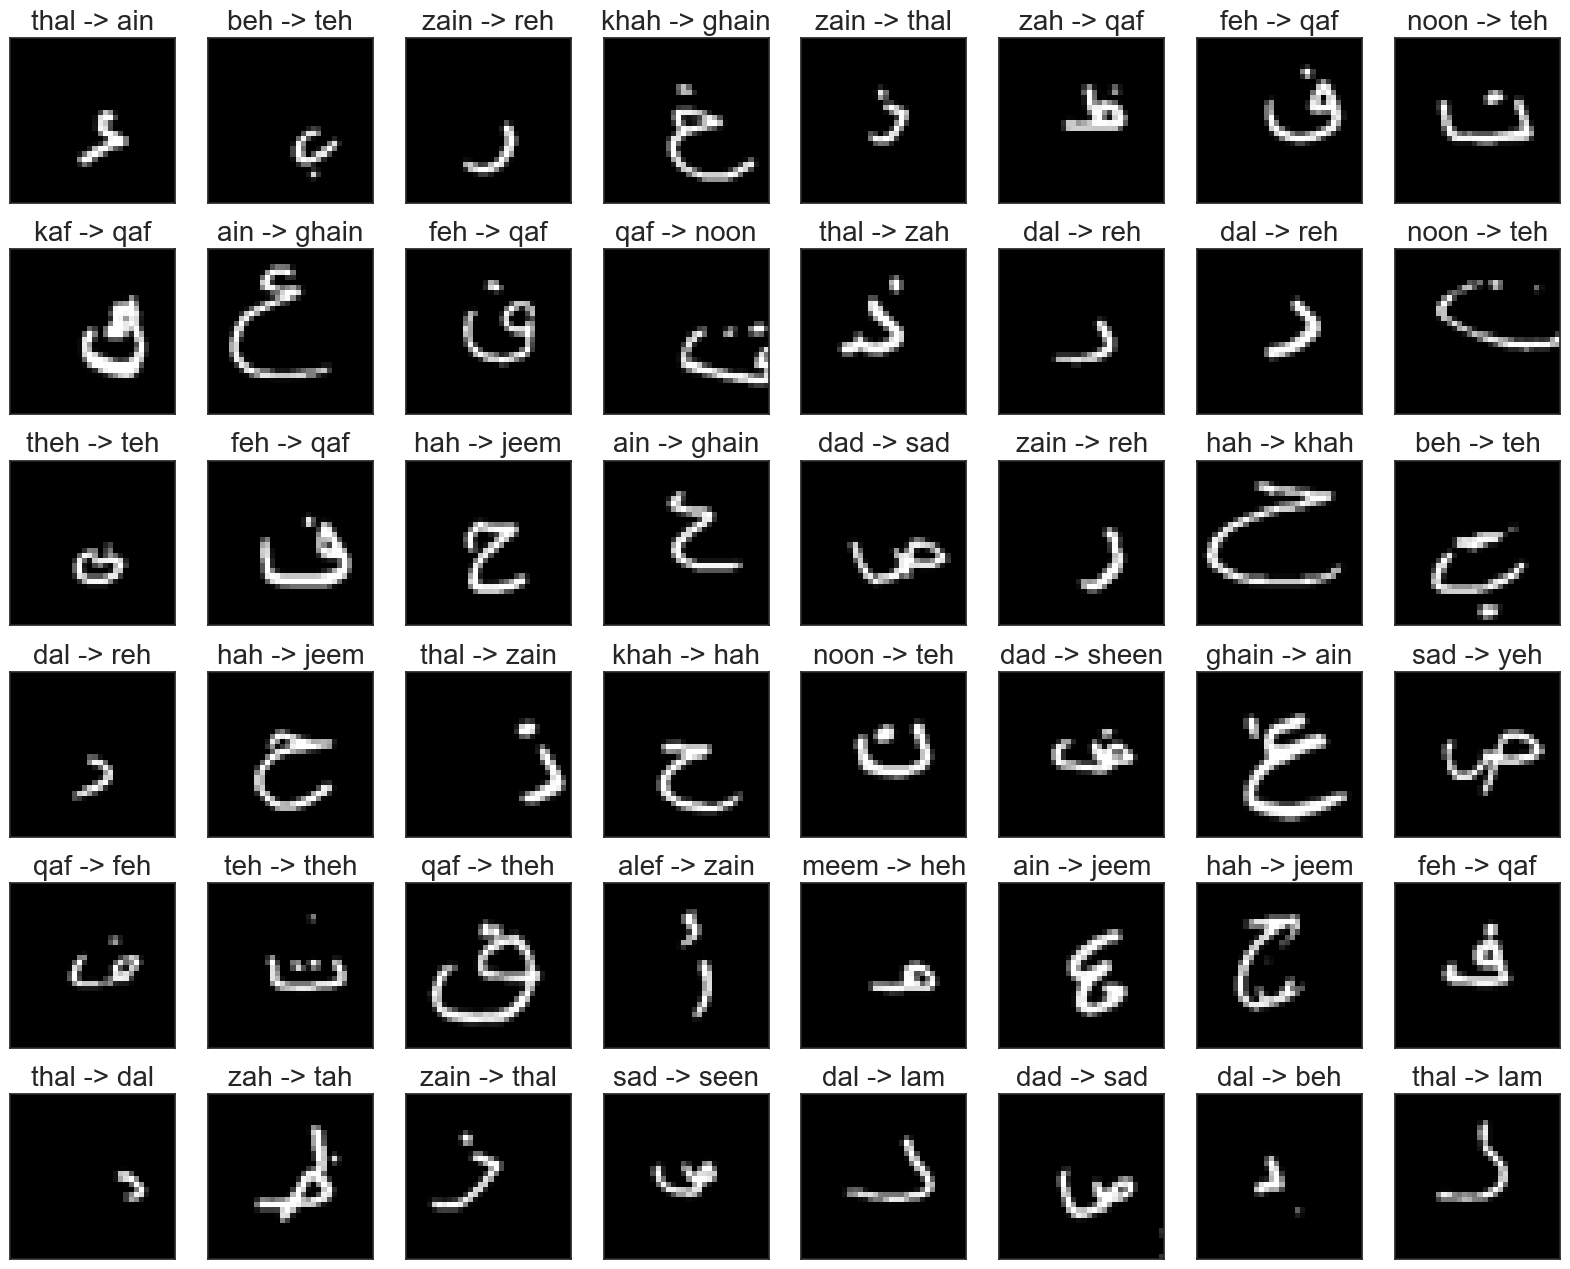

<Figure size 640x480 with 0 Axes>

In [ ]:
i = 0
plt.figure(figsize = (20, 16))
for j in range (len(y_test)):
    if y_test[j] != pred[j]:
        plt.subplot(6,8,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test[j].reshape(32,32),"gray")
        plt.title('{} -> {}'.format(arabic_characters[int(y_test[j])], arabic_characters[int(pred[j])]), fontsize = 20)
        #plt.xlabel(arabic_characters[int(y_test[j])], fontsize=20)
        i+=1
    if i >= 48:
        break
plt.show()
plt.savefig('misclassified.png')

## Prediction of Characters by inputing images

1/1 [==============================] - 0s 73ms/step
Predicted label: sad


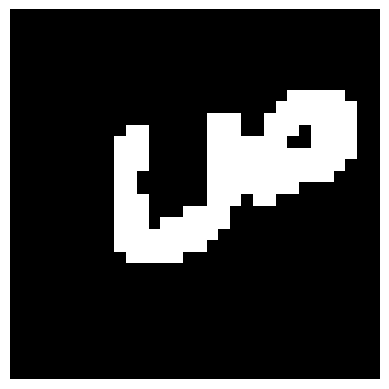

In [ ]:
image_path = r'C:\Users\arfan\OneDrive\Desktop\Sem 6\CSP650\Dataset\Test Images 3360x32x32\test\sad\id_475_label_14.png'
model_path = r'c:\Users\arfan\OneDrive\Desktop\Sem 6\CSP650\Results n Finding\CNN\8 by 2 split\Epoch 50\CNN_Epoch50_(8.2).h5'

import cv2

def predict_image(image_path, model_path):
    # Load the model
    # model = load_model(model_path)

    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (32, 32))
    img = img.reshape(1, 32, 32, 1)
    img = img.astype('float32') / 255.0

    # Make the prediction
    pred = model.predict(img)
    predicted_label = arabic_characters[np.argmax(pred)]

    return predicted_label

def plot_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Plot the image
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

prediction = predict_image(image_path, model_path)
print('Predicted label:', prediction)
plot_image(image_path)